# Single-Cell RNA-seq Analysis Pipeline (Conventional)

## 1. Install Required Libraries
**Purpose:** Install the core packages needed for single-cell data analysis.

In [46]:
# Core tools for single-cell RNA-seq and visualization
!pip install scanpy scvi-tools mygene matplotlib seaborn pandas numpy anndata

# Deep learning-based denoising tool
!pip install dca

# Clustering backends
!pip install leidenalg python-igraph louvain

# Gene Set Enrichment Analysis
!pip install gseapy


  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)


## 2. Import Libraries

**Purpose:** Load Python packages used throughout the notebook.

In [47]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 3. Set Plotting Parameters
**Purpose:** Ensure high-quality and consistent figures.

In [48]:
sc.set_figure_params(dpi=100, figsize=(4, 4))
plt.rcParams['figure.dpi'] = 100

## 4. Load Data

**Purpose:** Load your single-cell dataset stored in `.h5ad` format.

In [49]:
from google.colab import drive
# Importing files from your Google Drive
drive.mount('/content/drive')
adata = sc.read_h5ad('/content/drive/MyDrive/Single_Cell_Genomic_Analysis_Using_Machine_Learning/data/CHLA9.h5ad')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [50]:
print(adata)

AnnData object with n_obs × n_vars = 4800 × 13287


## 5. Inspect Metadata

**Purpose:** Understand structure of cell (`.obs`) and gene (`.var`) metadata.

In [51]:
print("Cell metadata (obs):")
print(adata.obs.head())

print("Gene metadata (var):")
print(adata.var.head())

Cell metadata (obs):
Empty DataFrame
Columns: []
Index: [AAACCCAGTTGTACGT-1, AAACGAAAGACCCGCT-1, AAACGAACAGCCTATA-1, AAACGAAGTGGCTAGA-1, AAACGAATCGAATCCA-1]
Gene metadata (var):
Empty DataFrame
Columns: []
Index: [AL669831.5, LINC00115, FAM41C, AL645608.7, AL645608.3]


## 6 Remove Duplicate Gene Names

**Purpose:** Ensure gene names are unique to avoid processing errors.

In [52]:
adata.var_names_make_unique()

## 7. Calculate Quality Control (QC) Metrics

**Purpose:** Assess cell quality using mitochondrial gene content and gene/cell counts.

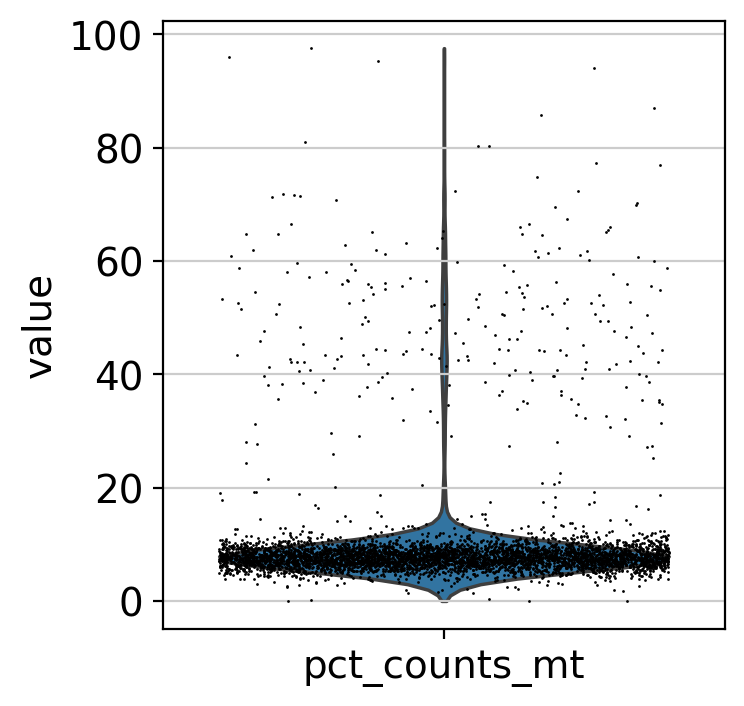

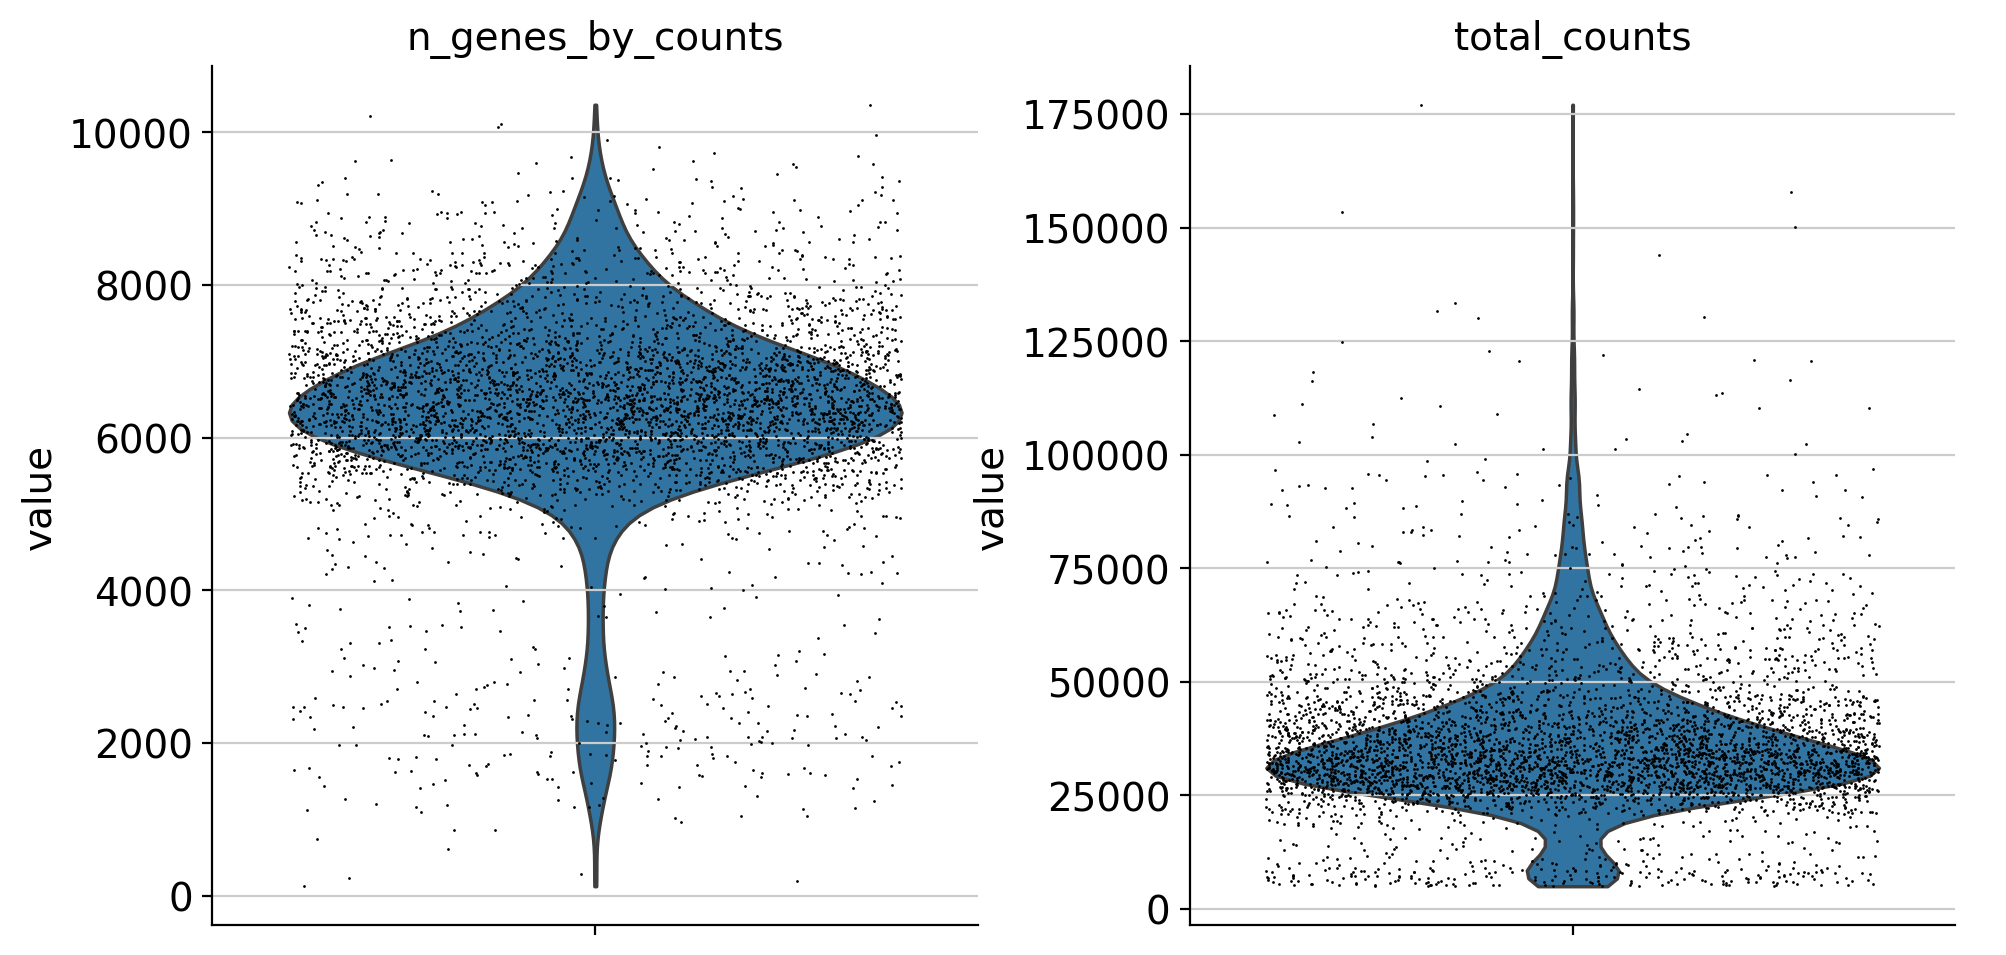

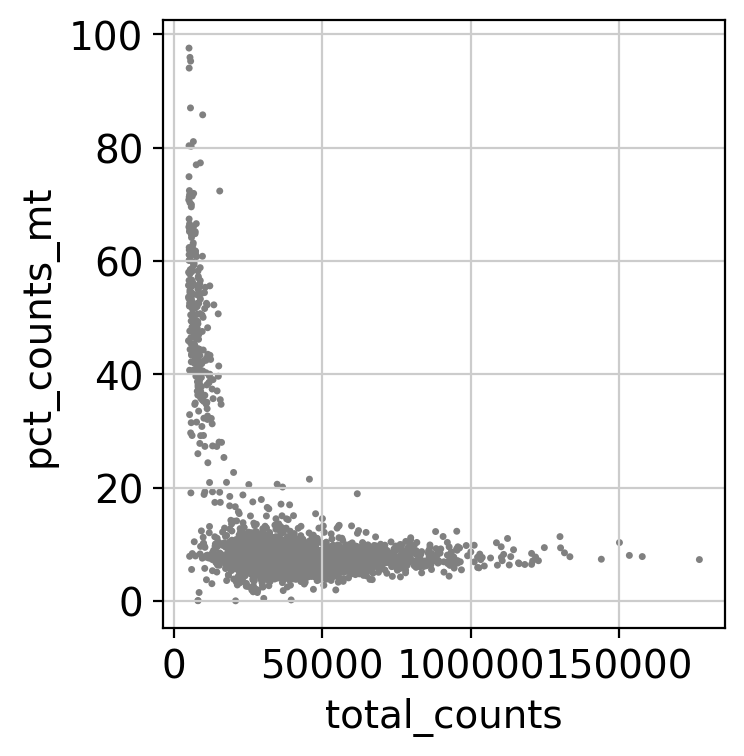

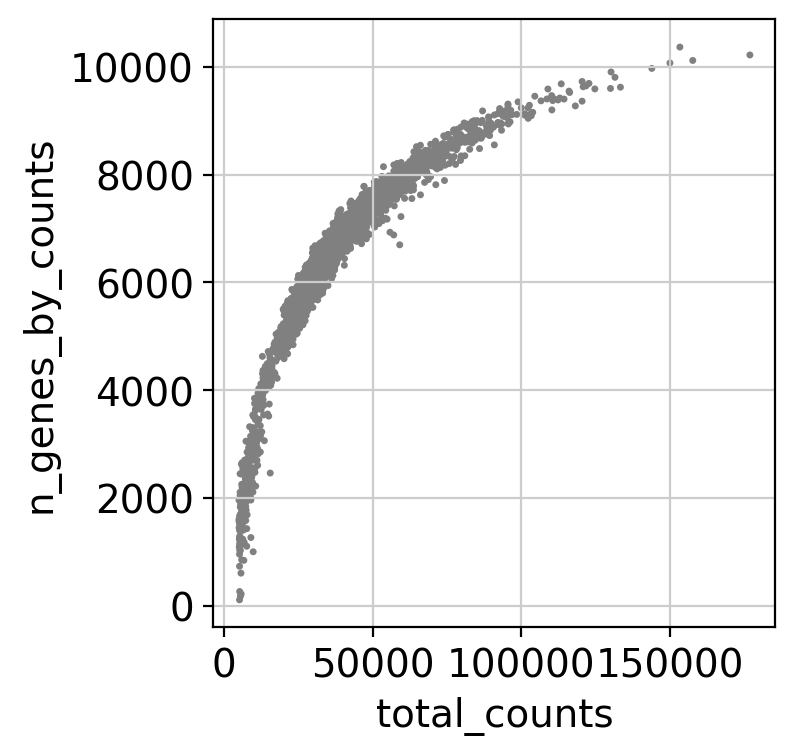

In [53]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata, ['pct_counts_mt'], jitter=0.4)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

## 8. Filter Low-Quality Cells

**Purpose:** Remove cells with poor sequencing coverage or excessive mitochondrial gene content.

In [54]:
min_genes = 2500
max_genes = 7500
min_total_counts = 10000
max_total_counts = 75000
max_mito_pct = 15

adata_filtered = adata[
    (adata.obs.n_genes_by_counts > min_genes) &
    (adata.obs.n_genes_by_counts < max_genes) &
    (adata.obs.total_counts > min_total_counts) &
    (adata.obs.total_counts < max_total_counts) &
    (adata.obs.pct_counts_mt < max_mito_pct)
].copy()

print(f"Before filtering: {adata.n_obs} cells")
print(f"After filtering: {adata_filtered.n_obs} cells")

Before filtering: 4800 cells
After filtering: 3812 cells


## 9. Normalize & Log Transform

**Purpose:** Normalize gene expression counts per cell and apply log transformation.

In [55]:
sc.pp.normalize_total(adata_filtered, target_sum=1e4)
sc.pp.log1p(adata_filtered)
adata_filtered.raw = adata_filtered

## 10. Visualize QC After Filtering

**Purpose:** Confirm quality after filtering.

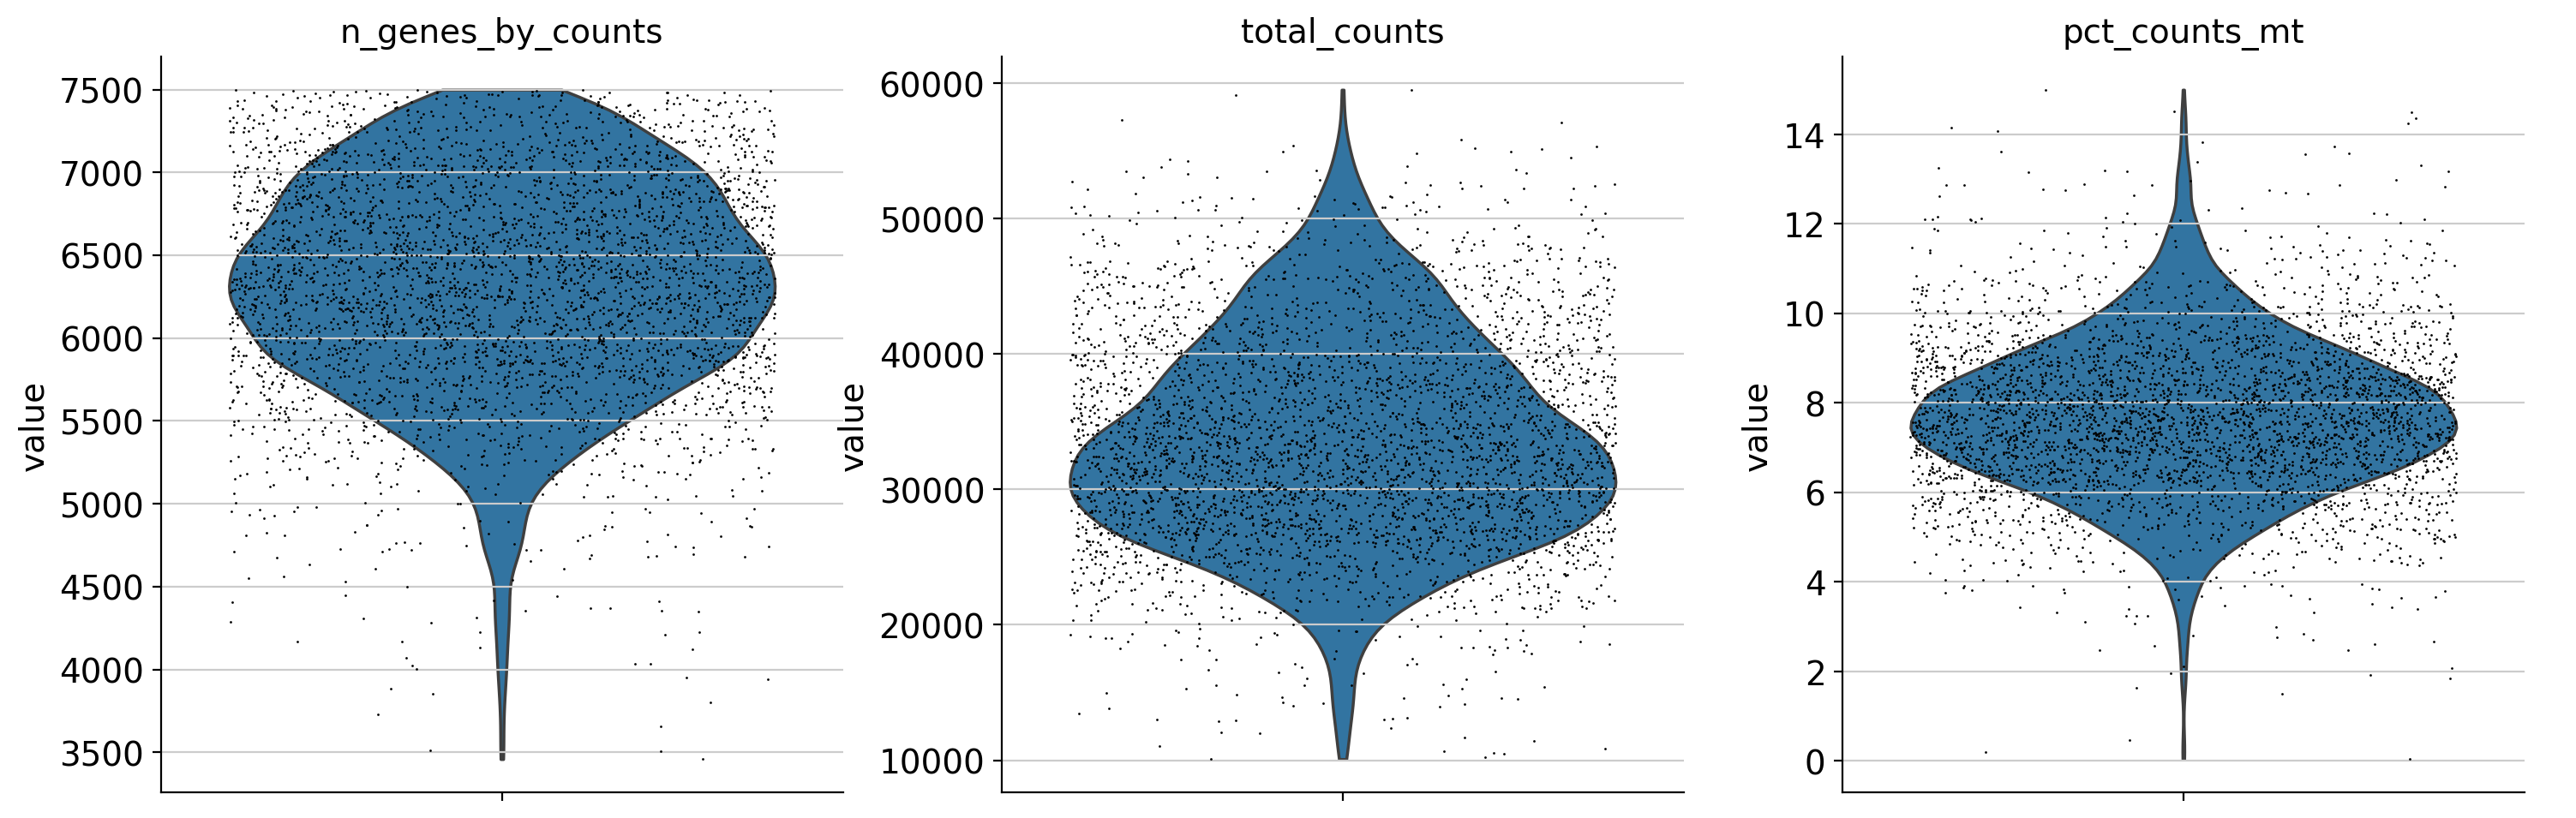

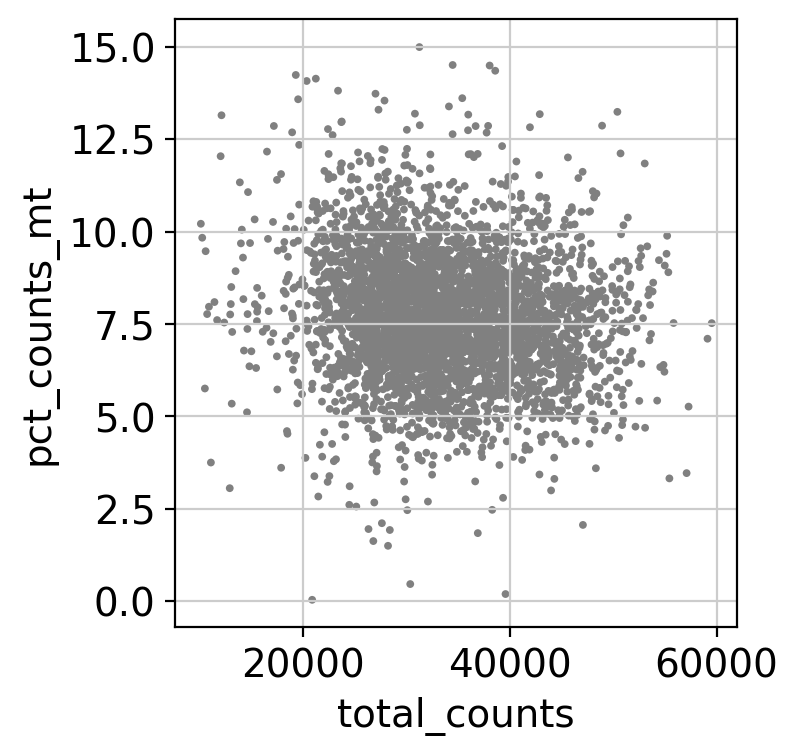

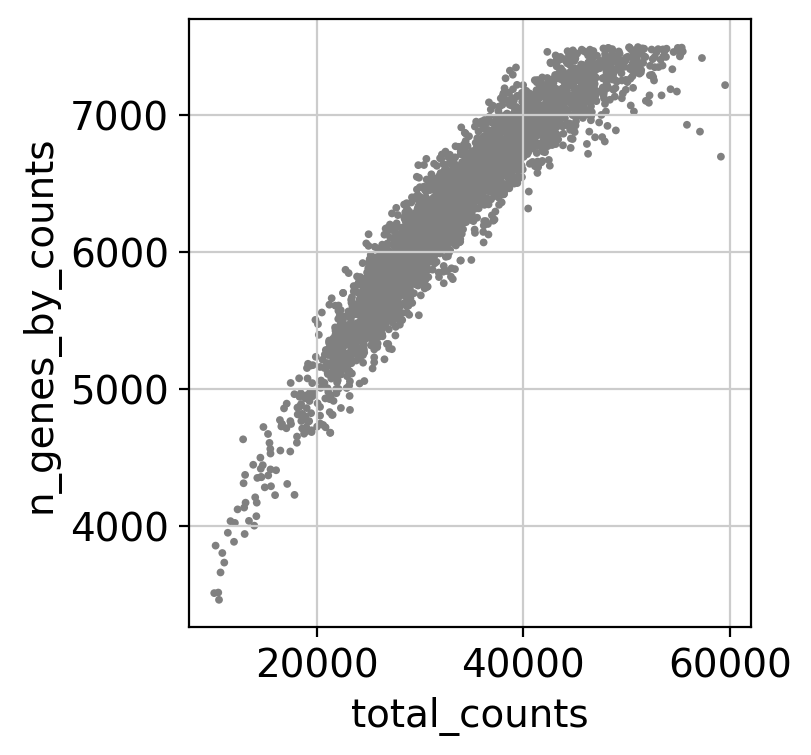

In [56]:
sc.pl.violin(adata_filtered, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_filtered, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_filtered, x='total_counts', y='n_genes_by_counts')

## 11. Identify Highly Variable Genes (HVGs)

**Purpose:** Select genes with the most informative variability.

In [57]:
sc.pp.highly_variable_genes(adata_filtered, n_top_genes=2000)
adata_filtered = adata_filtered[:, adata_filtered.var.highly_variable]
print(f"Reduced to {adata_filtered.n_vars} highly variable genes.")
sc.pp.scale(adata_filtered, max_value=10)

Reduced to 2000 highly variable genes.


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## 12. PCA and Compute Neighbors

**Purpose:** Reduce dimensionality and prepare neighborhood graph for clustering.

In [58]:
sc.tl.pca(adata_filtered, n_comps=50)
sc.pp.neighbors(adata_filtered, n_pcs=10)

## 13. UMAP Embedding

**Purpose:** Visualize cells in 2D based on similarity.

In [59]:
sc.tl.umap(adata_filtered)

## 14.. Cluster Cells (Leiden Algorithm)

**Purpose:** Group similar cells into clusters.

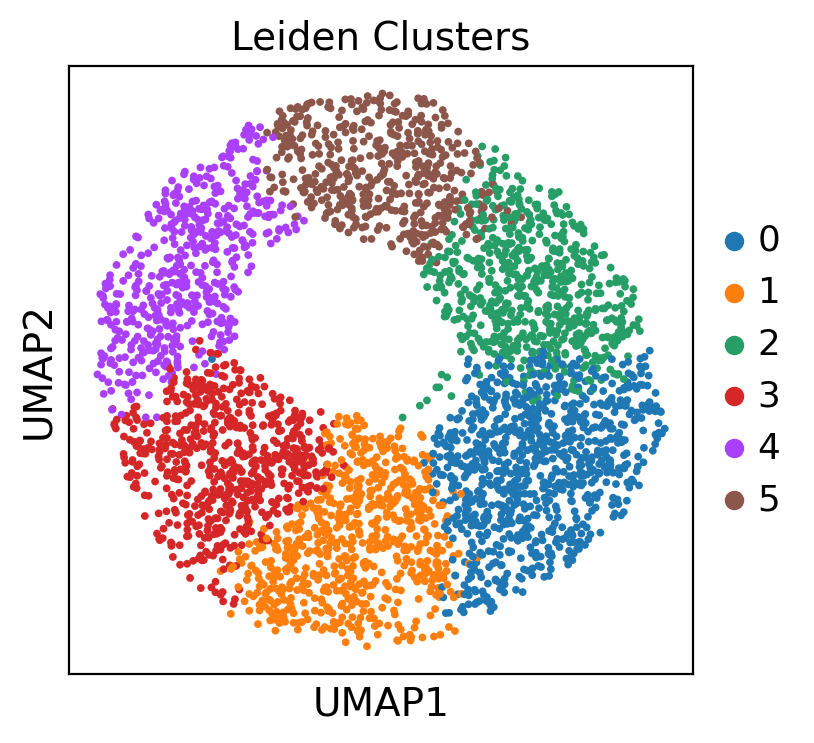

In [60]:
sc.tl.leiden(adata_filtered, resolution=0.6)
sc.pl.umap(adata_filtered, color='leiden', title='Leiden Clusters')

## 15. Marker Gene Identification

**Purpose:** Identify genes differentially expressed in each cluster.

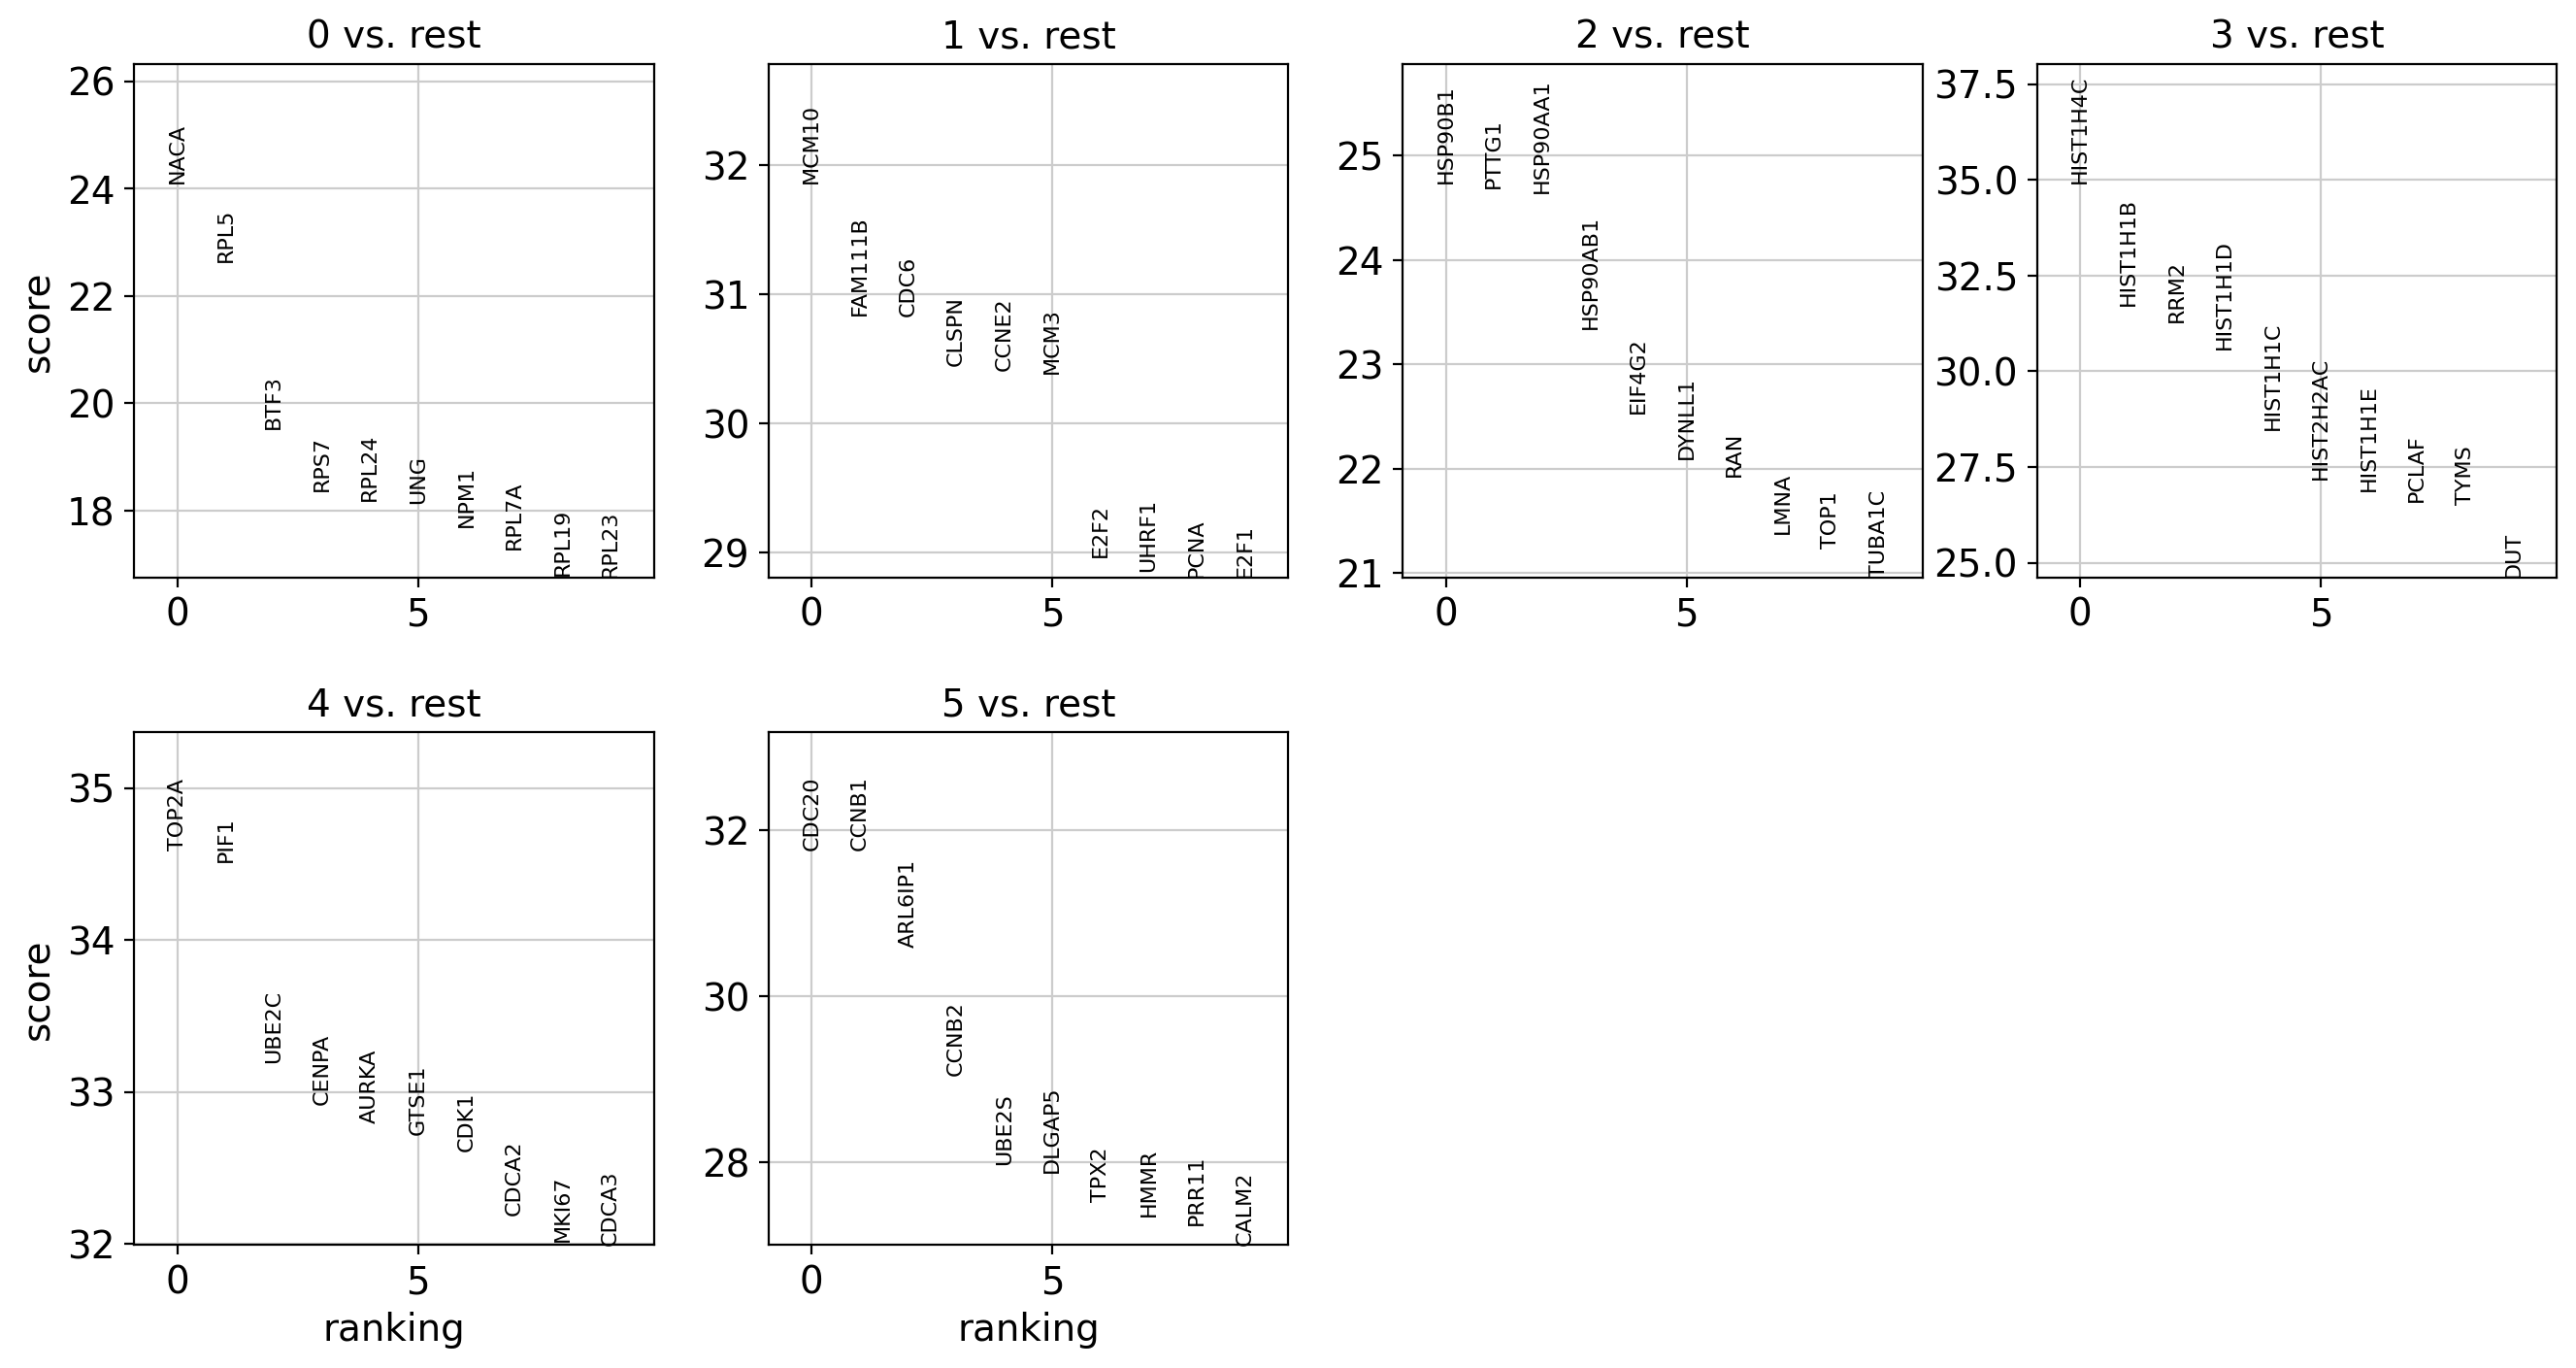

In [61]:
sc.tl.rank_genes_groups(adata_filtered, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata_filtered, n_genes=10, sharey=False)

## 16. Generate Cluster Dendrogram

**Purpose:** Visualize cluster similarities hierarchically.

In [62]:
sc.tl.dendrogram(adata_filtered, groupby='leiden')

## 17. Define Cell Type Marker Gene Sets

**Purpose:** List known gene markers for biological interpretation of clusters.

In [63]:
marker_dict = {
    'Ewing_tumor': ['CD99', 'FLI1', 'EWSR1', 'NKX2-2'],
    'Cycling_cell': ['MKI67', 'TOP2A', 'PCNA'],
    'MSC_like': ['CD44', 'VCAM1', 'ENG'],
    'T_cell': ['CD3D', 'CD3E', 'IL7R'],
    'B_cell': ['CD79A', 'MS4A1', 'CD19'],
    'NK_cell': ['NKG7', 'GNLY', 'KLRD1'],
    'Monocyte': ['LYZ', 'S100A9', 'CD14'],
    'Dendritic_cell': ['FCER1A', 'CD1C', 'CLEC9A'],
    'Endothelial': ['PECAM1', 'VWF', 'CD34'],
    'Fibroblast': ['DCN', 'COL1A1', 'ACTA2'],
    'Immune_evasion': ['B2M', 'TGFBI', 'CD47', 'SERPINB9'],
    'antitumor_genes': ['G2MB', 'PRF1', 'IFNG', 'GNLY', 'NKG7']
}

## 18. Filter Missing Marker Genes

**Purpose:** Keep only marker genes present in the dataset.

In [64]:
all_marker_genes = [gene for genes in marker_dict.values() for gene in genes]
missing_genes = [g for g in all_marker_genes if g not in adata_filtered.var_names]
print("Missing genes:", missing_genes)

filtered_marker_dict = {
    label: [gene for gene in genes if gene in adata_filtered.var_names]
    for label, genes in marker_dict.items()
}
filtered_marker_dict = {k: v for k, v in filtered_marker_dict.items() if v}
print("Final marker categories:", filtered_marker_dict.keys())

Missing genes: ['FLI1', 'EWSR1', 'CD44', 'VCAM1', 'ENG', 'CD3D', 'CD3E', 'IL7R', 'MS4A1', 'CD19', 'NKG7', 'GNLY', 'KLRD1', 'LYZ', 'S100A9', 'CD14', 'FCER1A', 'CD1C', 'CLEC9A', 'PECAM1', 'VWF', 'CD34', 'TGFBI', 'CD47', 'SERPINB9', 'G2MB', 'PRF1', 'IFNG', 'GNLY', 'NKG7']
Final marker categories: dict_keys(['Ewing_tumor', 'Cycling_cell', 'B_cell', 'Fibroblast', 'Immune_evasion'])


## 19. Dotplot of Marker Genes

**Purpose:** Visualize expression of known marker genes across clusters.

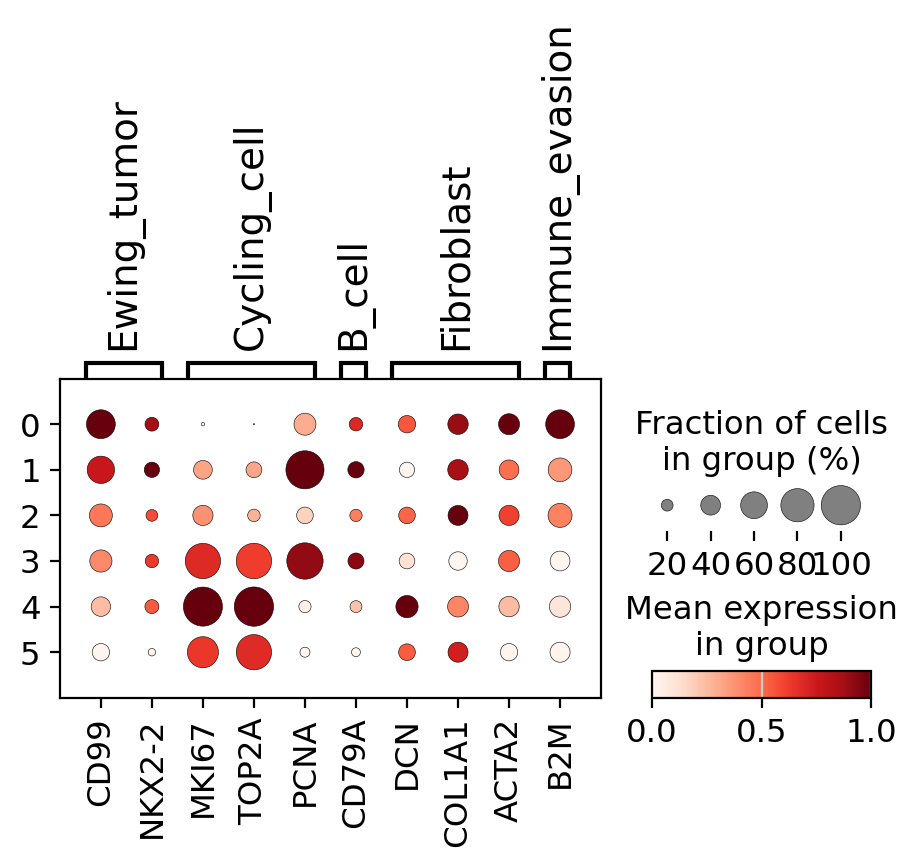

In [65]:
sc.pl.dotplot(
    adata_filtered,
    var_names=filtered_marker_dict,
    groupby='leiden',
    standard_scale='var',
    use_raw=False
)

## 20. Visualize Marker Genes on UMAP

**Purpose:** Show spatial distribution of marker genes.

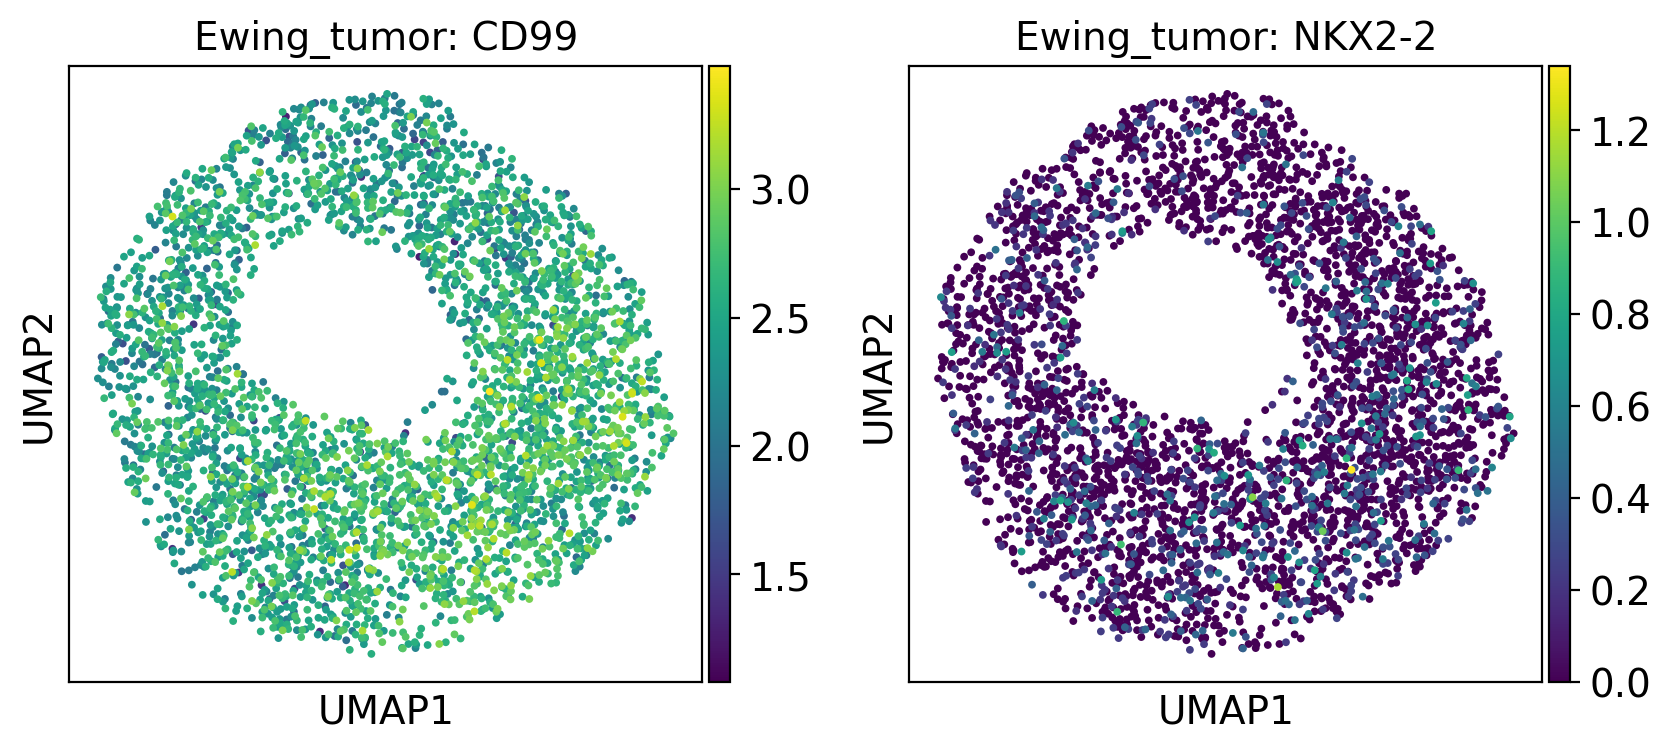

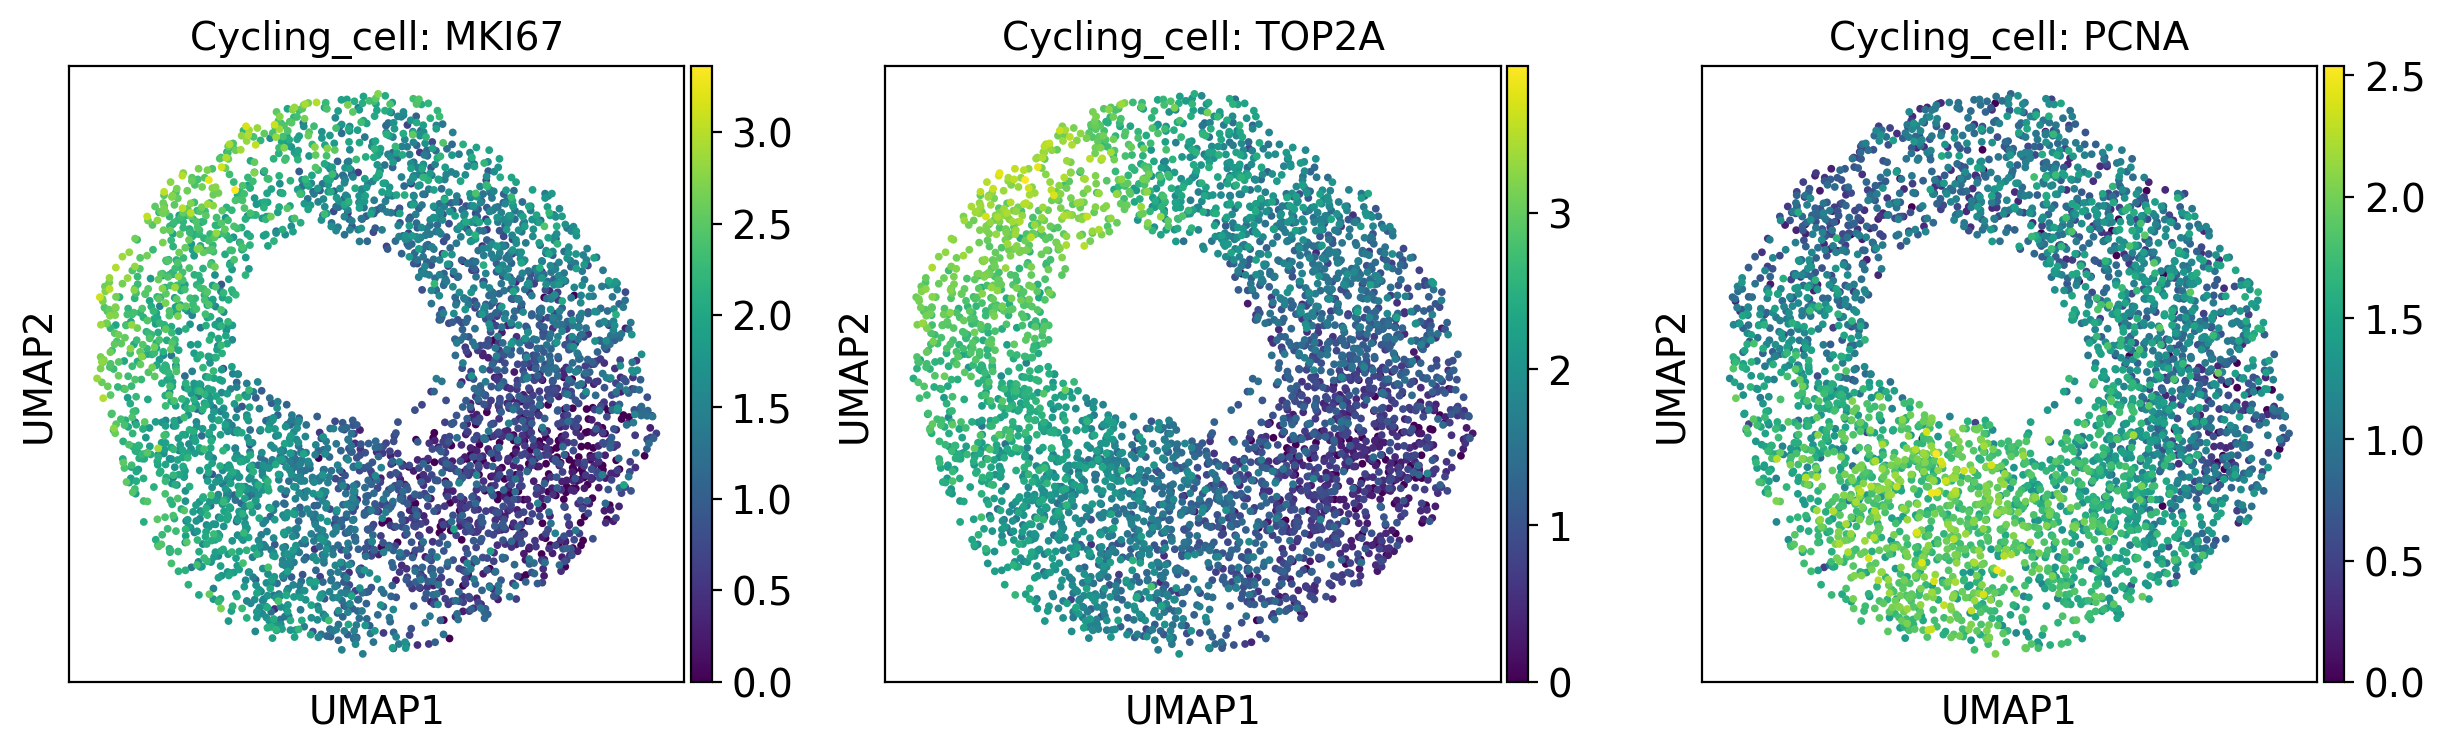

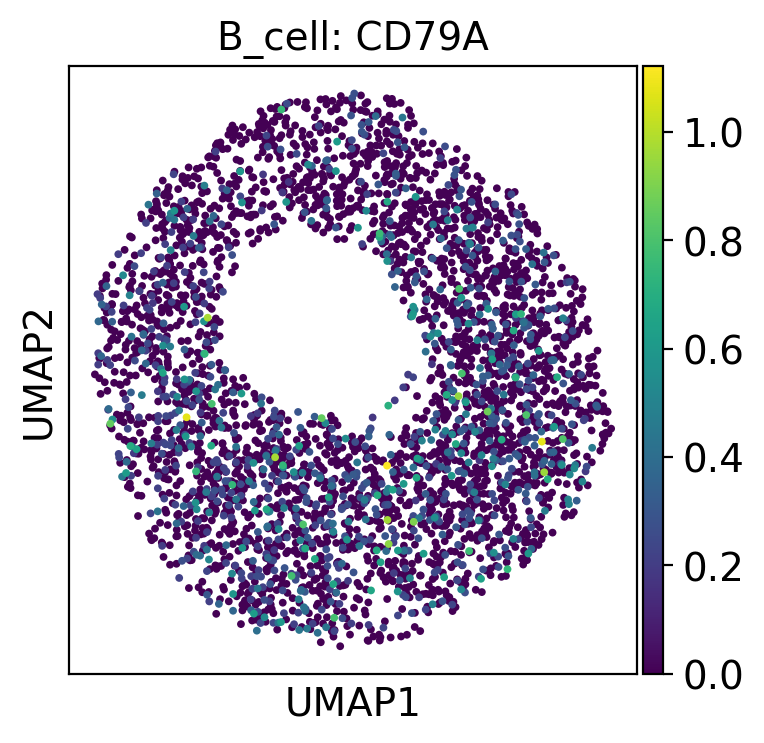

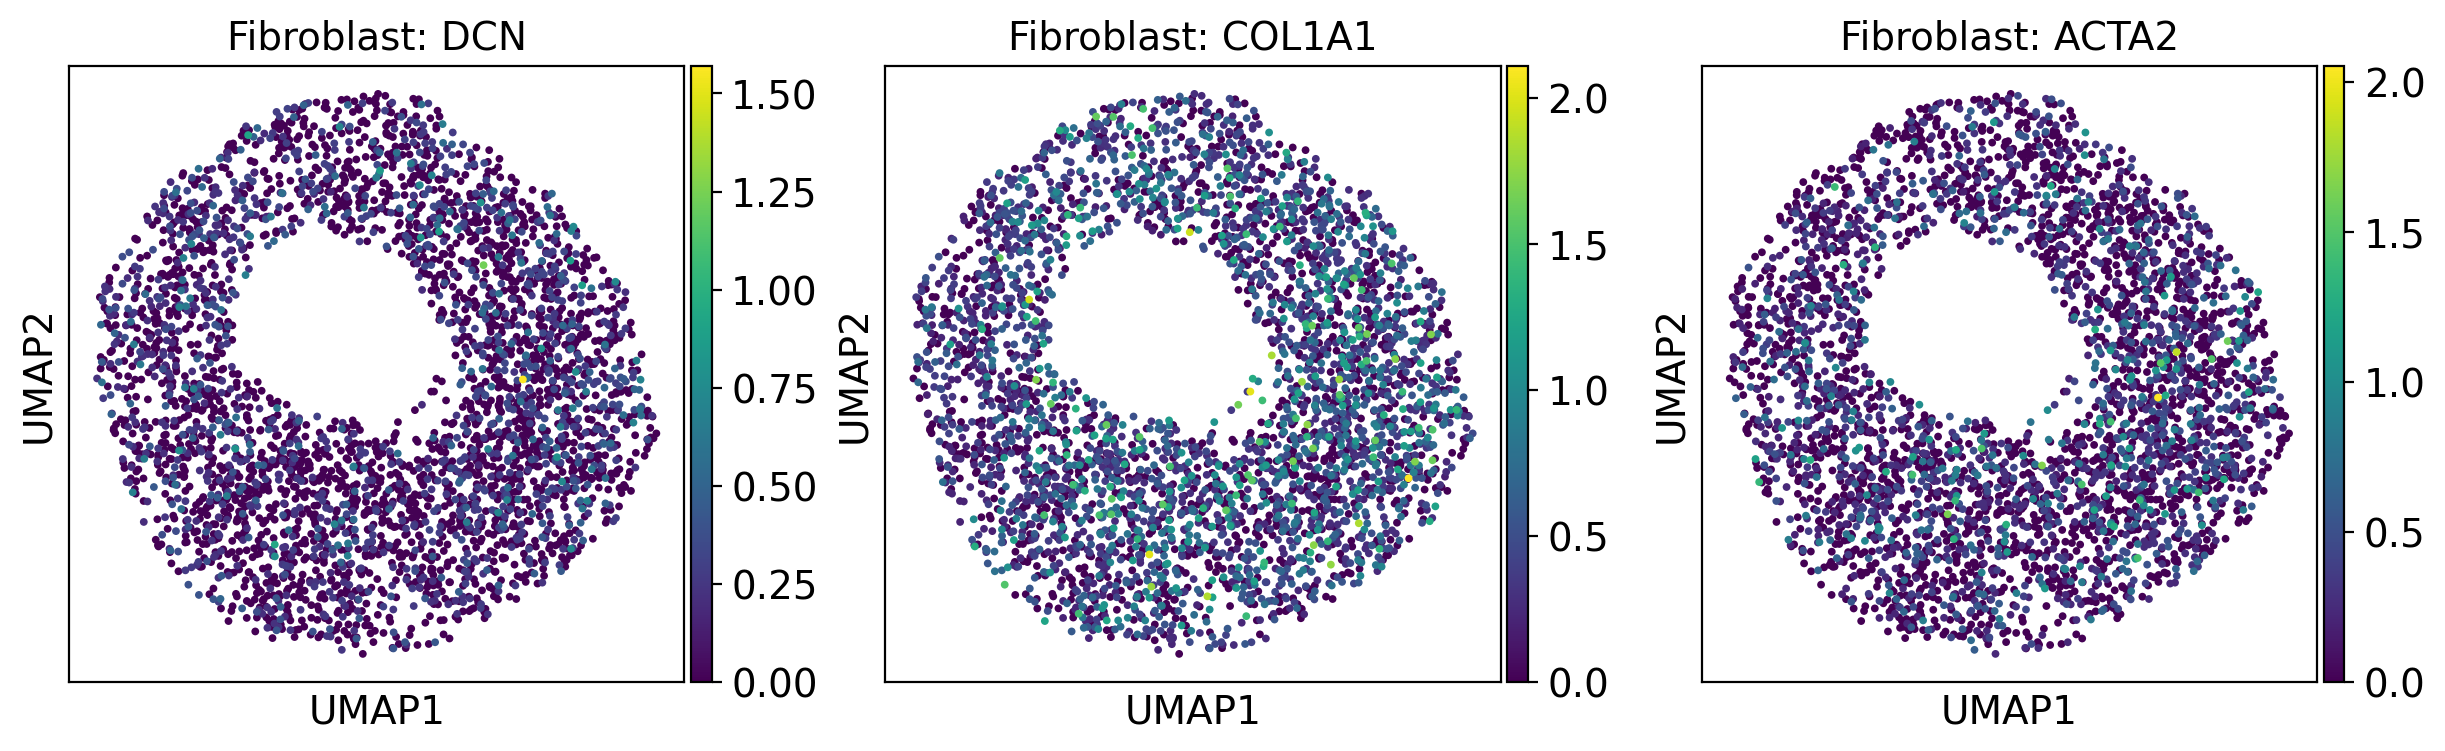

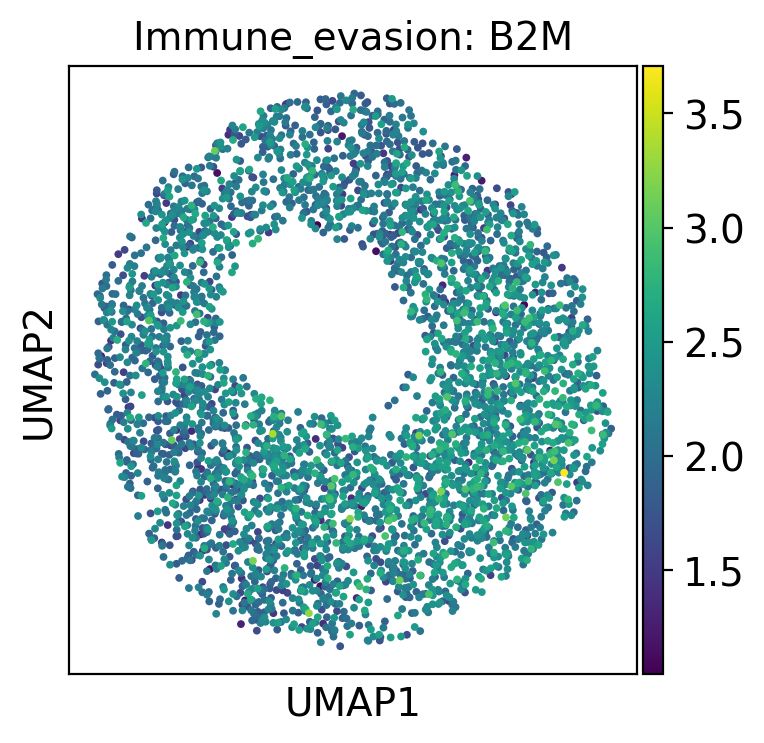

In [66]:
for label, genes in filtered_marker_dict.items():
    sc.pl.umap(
        adata_filtered,
        color=genes,
        title=[f"{label}: {gene}" for gene in genes],
        ncols=3
    )

# END